In [1]:
import sys
sys.path.append('/scratch/gf332/Misc/BVAE/code')

import tensorflow as tf
import tensorflow_probability as tfp
import tensorflow_datasets as tfds

from bnn import MnistBNN

import matplotlib.pyplot as plt

tfd = tfp.distributions

data_dir = "/scratch/gf332/Misc/datasets/"

In [2]:
# Set CPU as available physical device
tf.config.experimental.set_visible_devices([], 'GPU')

In [3]:
mnist = tfds.load("mnist", data_dir=data_dir)

In [4]:
model_save_dir = "/scratch/gf332/Misc/bnn_experiments/bnn/adaptive_sghmc/prior_per_param"

In [5]:
model = MnistBNN(prior_mode="per_param")
model.build(input_shape=(1, 28, 28, 1))

ckpt = tf.train.Checkpoint(model=model)

manager = tf.train.CheckpointManager(ckpt, model_save_dir, max_to_keep=3)

# Restore previous session
ckpt.restore(manager.latest_checkpoint)#.expect_partial()
if manager.latest_checkpoint:
    print(f"Restored model from {manager.latest_checkpoint}")
else:
    print("Initializing model from scratch.")

Restored model from /scratch/gf332/Misc/bnn_experiments/bnn/adaptive_sghmc/prior_per_param/ckpt-91


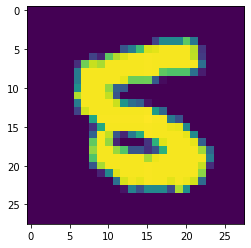

tf.Tensor(
[[ -2.9063418 -30.038784   -0.7467554   4.5077996  -6.566862   10.432085
   -3.5446682  -5.1199117   5.3604703 -16.176859 ]], shape=(1, 10), dtype=float32)
Actual:  5
Prediction: 5


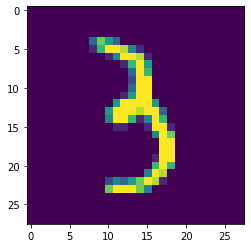

tf.Tensor(
[[ -4.941402    -1.24308     -2.0569668    9.646105    -5.2893863
    0.33291882 -12.4261875   -2.4258108   -6.2025366   -5.890172  ]], shape=(1, 10), dtype=float32)
Actual:  3
Prediction: 3


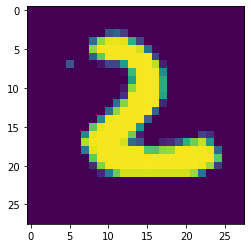

tf.Tensor(
[[ -7.040861  -12.693451    8.231148   -5.211893   -5.0717673 -10.74704
   -5.6411166  -7.023236  -11.600826  -26.44143  ]], shape=(1, 10), dtype=float32)
Actual:  2
Prediction: 2


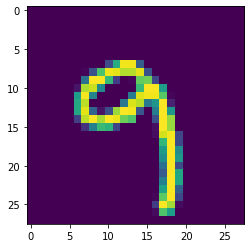

tf.Tensor(
[[ -5.2171016    2.1264126   -4.022136     2.0498466    3.4447782
   -0.46205133 -15.906575     5.2391157   -2.547352    16.039148  ]], shape=(1, 10), dtype=float32)
Actual:  9
Prediction: 9


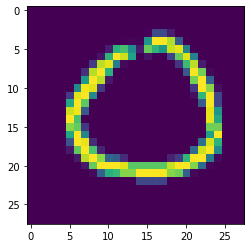

tf.Tensor(
[[  8.9484     -11.770701     0.04051614  -3.1389208   -5.2703896
   -3.521725    -5.430851    -6.104267    -7.223953   -19.172302  ]], shape=(1, 10), dtype=float32)
Actual:  0
Prediction: 0


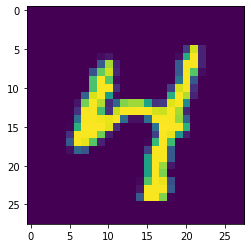

tf.Tensor(
[[ -3.4756026  -26.255003    -3.8005798   -0.67706734  13.430942
   -4.2856746  -13.413521     3.7816606  -11.863081    -4.6210623 ]], shape=(1, 10), dtype=float32)
Actual:  4
Prediction: 4


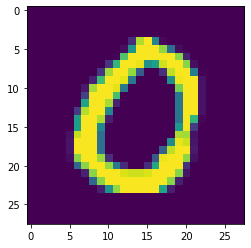

tf.Tensor(
[[ 10.963489   -25.299719     0.84482914  -4.8080025   -2.567777
   -5.399501    -9.713406    -3.2818022   -8.232337    -2.7994058 ]], shape=(1, 10), dtype=float32)
Actual:  0
Prediction: 0


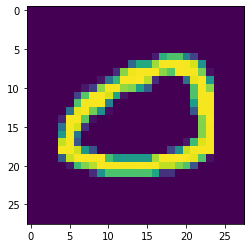

tf.Tensor(
[[ 10.013505  -19.404263    0.6867559  -4.6637287  -2.9631991  -4.301233
   -8.831817   -1.8759841  -8.863791   -8.154545 ]], shape=(1, 10), dtype=float32)
Actual:  0
Prediction: 0


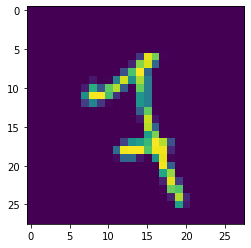

tf.Tensor(
[[ -5.6863337    1.2567499   -0.77784044   3.7383723   -4.105837
   -6.8471956  -15.742126    -1.1904851   -4.5449386   -4.672344  ]], shape=(1, 10), dtype=float32)
Actual:  7
Prediction: 3


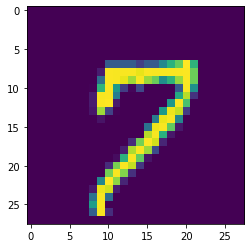

tf.Tensor(
[[ -2.173157   -31.764954     0.47566336  -3.6310225   -1.0070205
    1.2013202  -13.090099    13.198156    -2.7277153    6.471917  ]], shape=(1, 10), dtype=float32)
Actual:  7
Prediction: 7


In [6]:
test_ds = mnist['test']
test_ds = test_ds.map(lambda x: (tf.cast(x["image"], tf.float32) / 255., x["label"])).shuffle(300)

for im, label in test_ds.batch(1).take(10):
    
    plt.figure()
    plt.imshow(im[0, ..., 0])
    plt.show()
    
    probs = model(im)
    
    print(probs)
    
    print("Actual: ", label[0].numpy())
    print("Prediction:", tf.argmax(probs, axis=1)[0].numpy())

In [7]:
test_accuracy = 0.
total_size = 0.

batch_size = 500

for im, label in test_ds.batch(batch_size).take(1):
    
    probs = model(im)
    
    test_accuracy += tf.reduce_sum(tf.cast(tf.argmax(probs, axis=1) == label, tf.float32))
    
    total_size += tf.cast(label.shape[0], tf.float32)
    
test_accuracy = test_accuracy / total_size

In [8]:
test_accuracy

<tf.Tensor: shape=(), dtype=float32, numpy=0.982>

In [9]:
model.transforms[0].kernel_rate

<tf.Variable 'conv_0/kernel_rate:0' shape=(5, 5, 1, 32) dtype=float32, numpy=
array([[[[1.02480793e+00, 1.34106398e+00, 1.57526188e+01,
          2.53988876e+01, 1.05594146e+00, 9.29121094e+01,
          1.03404284e+00, 1.80751538e+00, 6.12273121e+00,
          6.66331530e+00, 1.03972411e+00, 1.80104411e+00,
          1.01675308e+00, 1.04486072e+00, 1.20459259e+00,
          3.17158294e+00, 1.17082214e+00, 1.00564301e+00,
          1.23903561e+00, 1.02553558e+00, 1.18035734e+00,
          2.85290217e+00, 2.02858543e+00, 2.58802843e+00,
          1.03046882e+00, 4.19105911e+00, 6.57534981e+00,
          1.83032405e+00, 2.05081677e+00, 3.79409885e+00,
          1.51114016e+01, 1.12487841e+00]],

        [[2.53339028e+00, 1.40009761e+00, 3.58581390e+01,
          2.68976593e+01, 1.00054014e+00, 1.11877197e+02,
          1.98974204e+00, 2.78275037e+00, 1.05884562e+01,
          1.76505280e+01, 3.44540763e+00, 1.09368527e+00,
          1.37537122e+00, 1.26706266e+00, 1.25347102e+00,
       